In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
from PIL import Image
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

from pathlib import Path

from pyproj import Transformer

from functools import partial
from collections import OrderedDict

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle

import time
import pickle

In [2]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
loss(input, target)

tensor(2.7926, grad_fn=<NllLossBackward>)

In [3]:
input.shape

torch.Size([3, 5])

In [4]:
target.shape

torch.Size([3])

In [5]:
n_components = 3
n_channels = 28
chip_size = 64
train_ratio = 0.8 # ratio of train size to fullsize

chips_root = r'C:\Users\mouju\Desktop\film\raster_chips\concat_geo90_arcticdem'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

L2_param = 1e-5

transformer = Transformer.from_crs("epsg:4326", "epsg:3413")

models_dir = 'res_shap/'
Path(models_dir).mkdir(parents=True, exist_ok=True)

train_max_epoch = 50

In [6]:
with open('components_analysis/mix_n{}.npy'.format(n_components), 'rb') as f:
    mix = np.load(f)

In [7]:
mix.shape

(561, 3)

In [8]:
dominant_profile = np.argmax(mix, -1)

In [9]:
df = pd.read_csv('components_analysis/df_unique.csv', header=[0])
df.borehole = df.borehole.str.replace('//', '--')
df['proj_x'], df['proj_y'] = transformer.transform(df.latitude,df.longitude)

In [10]:
df['dominant_profile'] = dominant_profile

In [11]:
df['latitude'].mean()

68.7847711764706

In [12]:
df.longitude.mean()

-133.49410438502673

In [13]:
for i in range(mix.shape[1]):
    df['component{}'.format(i)] = mix[:, i]

In [14]:
df.head()

,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,...,month,year,month_cyclic,visible_ice_code,proj_x,proj_y,dominant_profile,component0,component1,component2
0,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.85,1,NaN,Pure ice,ICE,Ice,...,3,2012,3,4,-2.280305e+06,-76170.639998,0,3.020992,0.351328,-1.557754
1,69.16105,-133.08880,2012-03-21T00:00:00Z,0170-1-12,1.20,1,Nf,No visible ice,GP-GM,Coarse till,...,3,2012,3,0,-2.280371e+06,-76093.964428,0,0.000000,0.000000,0.000000
2,69.15849,-133.08865,2012-03-20T00:00:00Z,0170-1-17,1.45,1,NaN,No visible ice,SM-SC,Sand,...,3,2012,3,0,-2.280657e+06,-76109.484296,1,-5.746523,-0.052054,-0.600771
3,69.15908,-133.08968,2012-03-20T00:00:00Z,0170-1-18,1.20,1,NaN,No visible ice,ML,Silt,...,3,2012,3,0,-2.280593e+06,-76066.285386,1,-5.746523,-0.052054,-0.600771
4,69.15886,-133.09090,2012-03-21T00:00:00Z,0170-1-19,1.20,1,Nf,No visible ice,GP,Gravel,...,3,2012,3,0,-2.280619e+06,-76018.544396,2,-5.850486,-0.905609,-0.506412


In [15]:
n_bh_temp = len(df)
df = df.query("borehole != 'ENG.YARC03097-01--HUS_H (NTGS 7)'")
df = df.query("borehole != 'W14103137-CR4N'")
df = df.query("borehole != 'W14103137-S6-BH15'")
df = df.query("borehole != 'W14103137-S6-BH14'")
df = df.query("borehole != 'W14103137-S6-BH16'")
print(f'Number of boreholes has decreased from {n_bh_temp} to {len(df)}')

Number of boreholes has decreased from 561 to 560


In [91]:
sum(df['dominant_profile'] == 2)

202

In [16]:
class resnet_shap_data(Dataset):
    def __init__(self, chips_root, df, chip_size=32):
        
        self.df = df
        self.chip_size = chip_size
        self.chips_root = chips_root  
            
        file_list = os.listdir(chips_root)
        with open(os.path.join(chips_root, file_list[0]), 'rb') as f:
            loaded = np.load(f)
        
        self.n_channels = loaded.shape[0]
        print("Dataset contains {} channels".format(self.n_channels))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        bh_id = row.at['borehole']
        
        with open(os.path.join(self.chips_root, f'{bh_id}.npy', ), 'rb') as f:
            loaded = np.load(f)
        
        if self.chip_size > loaded.shape[1]:
            raise IndexError(f'chip_size parameter {self.chip_size} bigger than size of prepared chips {loaded.shape[1]} in {self.chips_root}')
        
        start = int(loaded.shape[1] / 2) - int(self.chip_size/2)
        end = start + self.chip_size
        
        image= torch.tensor(loaded[:, start:end, start:end]).float()
        
        # visible_ice = torch.tensor(row.at['visible_ice']).float()
        # label_value = torch.tensor(row.at[self.label]).long()
        
        # material_ice = torch.tensor(row.at['material_ice']).float()
        
        
        return {'image': image, 'label': torch.tensor(row.at['dominant_profile'])}

In [17]:
full_dataset = resnet_shap_data(chips_root, df, chip_size)

Dataset contains 28 channels


In [30]:
def train(trainloader, testloader, print_epochs = False, loss_fn = torch.nn.CrossEntropyLoss()):
    
    model= models.resnet18()
    model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=n_components)
    
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), weight_decay = L2_param)

    epoch_loss = np.zeros([train_max_epoch, 2])
    for epoch in range(train_max_epoch):  # loop over the dataset multiple times

        model.train()
        running_loss_sum = 0.0
        for i, data in enumerate(trainloader, 0): # loop over each sample
            # get the inputs; data is a list of [inputs, labels]
            image, labels = data['image'].to(device), data['label'].to(device)

            predicted = model(image)

            
            
            # squeeze: return tensor with all dimensions of size 1 removed
            loss = loss_fn(predicted.squeeze(), labels)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss_sum += loss.item()

        # ----------- get validation loss for current epoch --------------
        model.eval()
        validation_loss_sum = 0.0
        for i, data in enumerate(testloader, 0): # loop over each sample

            image, labels = data['image'].to(device), data['label'].to(device)

            predicted = model(image)
            
            loss = loss_fn(predicted.squeeze(), labels)

            validation_loss_sum += loss.item()

        # ---------------- print statistics ------------------------

        running_loss = running_loss_sum / len(trainloader)
        validation_loss = validation_loss_sum / len(testloader)
        epoch_loss[epoch, :] =  [running_loss, validation_loss]
        
        if print_epochs:
            print('epoch %2d: running loss: %.5f, validation loss: %.5f' %
                          (epoch + 1, running_loss, validation_loss))
        
        torch.save(model.state_dict(), os.path.join(models_dir, 'epoch-{}.pt'.format(epoch+1)))
    
    if print_epochs:
        print('Finished Training')
        
    return epoch_loss
        
def test(epoch_loss, print_model_epoch = False):
    
    # ------ select model ---------
    weighted_loss = train_ratio*epoch_loss[:, 0] + (1-train_ratio) * epoch_loss[:,1]
    ind = np.argmin(weighted_loss)
    
    
    model= models.resnet18()
    model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=n_components)
    
    model.load_state_dict(torch.load('{}epoch-{}.pt'.format(models_dir, ind+1)))
    
    model.to(device)
    
    if print_model_epoch:
        print("epoch {} model selected".format(ind+1))
    
    # evaluate model on test set
    model.eval()

    with torch.no_grad():
        test_results = []
        
        for i, data in enumerate(testloader, 0):
            image, labels = data['image'].to(device), data['label'].to(device)
            # y_test.append(label.numpy().list())
            # print(label.shape)
            # print(images.shape)

            output = model(image)
            
            test_results.extend(output)
            
    return model, test_results

In [28]:
train_size = int(train_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size

# batchsize can cause error when last leftover batchsize is 1, batchnorm cannot function on 1 sample data
batchsize = 32
while(train_size % batchsize == 1):
    batchsize+=1
print(batchsize)

# train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])

trainloader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
testloader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

32


In [31]:
start = time.time()

epoch_loss = train(trainloader,testloader, print_epochs = True)

model, test_results= test(epoch_loss, print_model_epoch = True)

end = time.time()

# print(test_results)
print('iteration {} elapsed time: {}'.format(it+1, end-start))

epoch  1: running loss: 1.18950, validation loss: 3.40677
epoch  2: running loss: 0.94145, validation loss: 1.32185
epoch  3: running loss: 0.85278, validation loss: 1.12326
epoch  4: running loss: 0.69436, validation loss: 1.32288
epoch  5: running loss: 0.51121, validation loss: 1.89629
epoch  6: running loss: 0.61260, validation loss: 1.59809
epoch  7: running loss: 0.63140, validation loss: 1.58899
epoch  8: running loss: 0.41027, validation loss: 1.84000
epoch  9: running loss: 0.29934, validation loss: 2.45903
epoch 10: running loss: 0.41075, validation loss: 1.96450
epoch 11: running loss: 0.34994, validation loss: 2.06587
epoch 12: running loss: 0.22973, validation loss: 2.11353
epoch 13: running loss: 0.24153, validation loss: 2.42597
epoch 14: running loss: 0.18854, validation loss: 2.28749
epoch 15: running loss: 0.17084, validation loss: 2.56795
epoch 16: running loss: 0.18049, validation loss: 2.67324
epoch 17: running loss: 0.15464, validation loss: 2.59401
epoch 18: runn

In [32]:
trainloader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
testloader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

In [33]:
batch = next(iter(testloader))
print(batch['image'].shape)
test_images = batch['image'].to(device)

torch.Size([112, 28, 64, 64])


In [34]:
batch = next(iter(trainloader))
print(batch['image'].shape)
train_images = batch['image'].to(device)

torch.Size([448, 28, 64, 64])


In [35]:
import shap

In [36]:
explainer_gen = shap.DeepExplainer(model, train_images)


In [37]:
shap_values = explainer_gen.shap_values(test_images)


In [39]:
shap_values = np.array(shap_values)
shap_values.shape

(3, 112, 28, 64, 64)

In [40]:
np.save('shap_values_noseed.npy', shap_values)

In [74]:
shap_chips = np.sum(np.sum(abs(shap_values), -1), -1)
shap_samples = np.mean(shap_pixels, 1)
shap_channel = np.mean(shap_samples, 0) # averaged over classes

In [75]:
import matplotlib.pyplot as plt

In [76]:
temp_list = [None] * len(shap_chips) 

In [77]:
for i in range(len(shap_chips)):
    temp_list[i] = shap_chips[i]

In [ ]:
plt.barh(range(len(shap_channel)), np.sort(shap_channel))

# Feature names

In [78]:
data_root = r"C:\Users\mouju\Desktop\film\geomorph_data_epsg3413_10m"
n_channels = len(os.listdir(data_root))

file_list = os.listdir(data_root)

In [80]:
channel_names_list = []
for i, file in enumerate(file_list):
    name = file.split('_')[0]
    channel_names_list.append(name)

In [81]:
channel_names_list.extend(['dem', 'insolation','twi'])

In [85]:
len(temp_list)

3

In [86]:
temp_list[0].shape

(112, 28)

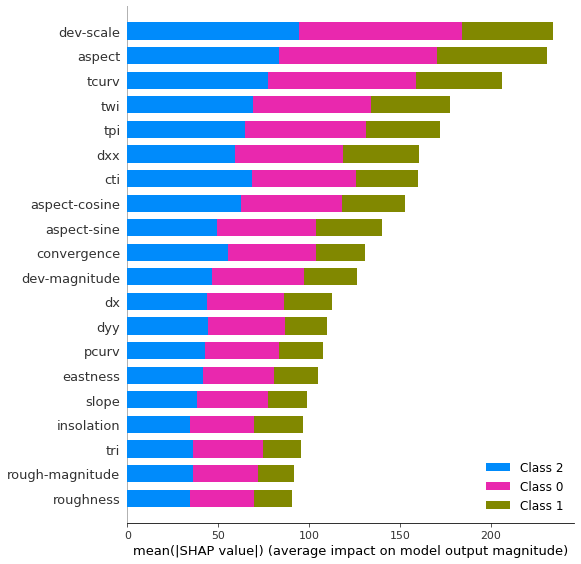

In [112]:
f = plt.gcf()
fig.subplots_adjust(left=1)
shap.summary_plot(temp_list, plot_type="bar", feature_names = channel_names_list, show=True)

In [115]:
f.subplots_adjust(left=0.5)
f.savefig('shap_geo90_arctic.png')

In [87]:
len(channel_names_list)

28